In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import os

In [2]:
# Set directories
main_dir = "Dataset/Data"
train_dir = os.path.join(main_dir, "train")
test_dir = os.path.join(main_dir, "test")
train_covid_dir = os.path.join(train_dir, "COVID19")
train_normal_dir = os.path.join(train_dir, "NORMAL")
test_covid_dir = os.path.join(test_dir, "COVID19")
test_normal_dir = os.path.join(test_dir, "NORMAL")

In [3]:
# F1Score metric class definition
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [4]:
# Data Augmentation and Preprocessing
dgen_train = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0, 1]
    validation_split=0.2,          # Use 20% for validation
    zoom_range=0.2,                # Random zoom
    horizontal_flip=True,          # Random horizontal flip
    rotation_range=30,             # Random rotations
    width_shift_range=0.2,         # Random width shift
    height_shift_range=0.2,        # Random height shift
    shear_range=0.2,               # Random shearing
    brightness_range=[0.8, 1.2]    # Random brightness
)

In [5]:
dgen_validation = ImageDataGenerator(
    rescale=1./255  # No augmentation for validation set
)

dgen_test = ImageDataGenerator(
    rescale=1./255  # No augmentation for test set
)

In [6]:
# Generate batches for training, validation, and testing
train_generator = dgen_train.flow_from_directory(
    train_dir,
    target_size=(64,64), 
    subset='training', 
    batch_size=32, 
    class_mode='categorical'
)

validation_generator = dgen_train.flow_from_directory(
    train_dir,
    target_size=(64,64), 
    subset='validation', 
    batch_size=32, 
    class_mode='categorical'
)

test_generator = dgen_test.flow_from_directory(
    test_dir,
    target_size=(64,64), 
    batch_size=32, 
    class_mode='categorical'
)

Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [7]:
print("Class Labels are: ", train_generator.class_indices)
print("Image shape is: ", train_generator.image_shape)

Class Labels are:  {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Image shape is:  (64, 64, 3)


In [13]:
# Updated Model Architecture for Code 1
model = Sequential()
# 1st Convolutional Block
model.add(Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=train_generator.image_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
# 2nd Convolutional Block
model.add(Conv2D(64, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
# 3rd Convolutional Block
model.add(Conv2D(128, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
# Flattening Layer
model.add(Flatten())
# Fully Connected Layer with Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# Final Output Layer
model.add(Dense(3, activation='softmax'))

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,356,289 (8.99 MB)

 Trainable params: 2,356,289 (8.99 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the Model with Custom Metrics
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', F1Score()])

In [15]:
# Training the Model 
history = model.fit(
    train_generator,
    epochs=100, 
    validation_data=validation_generator
)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - Precision: 0.6505 - Recall: 0.6214 - accuracy: 0.6416 - f1_score: 0.6350 - loss: 0.5413

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 96s 722ms/step - Precision: 0.6506 - Recall: 0.6217 - accuracy: 0.6417 - f1_score: 0.6352 - loss: 0.5411 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6644 - val_f1_score: 0.0000e+00 - val_loss: 0.6208
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 592ms/step - Precision: 0.6630 - Recall: 0.6603 - accuracy: 0.6631 - f1_score: 0.6617 - loss: 0.5055 - val_Precision: 1.0000 - val_Recall: 0.0039 - val_accuracy: 0.6644 - val_f1_score: 0.0078 - val_loss: 0.6098
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 63s 490ms/step - Precision: 0.6633 - Recall: 0.6566 - accuracy: 0.6593 - f1_score: 0.6599 - loss: 0.4887 - val_Precision: 0.7734 - val_Recall: 0.5214 - val_accuracy: 0.6907 - val_f1_score: 0.6229 - val_loss: 0.5472
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 510ms/step - Precision: 0.7015 - Recall: 0.6767 - accuracy: 0.6952 - f1_score: 0.6888 - loss: 0.4278 - val_Precision: 0.7596 - val_Recall: 0.6362 - val_accuracy: 0.7121 - val_f1_score: 0.

In [16]:
# KEYS OF HISTORY OBJECT
history.history.keys()

dict_keys(['Precision', 'Recall', 'accuracy', 'f1_score', 'loss', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_f1_score', 'val_loss'])

Text(0.5, 0, 'epoch')

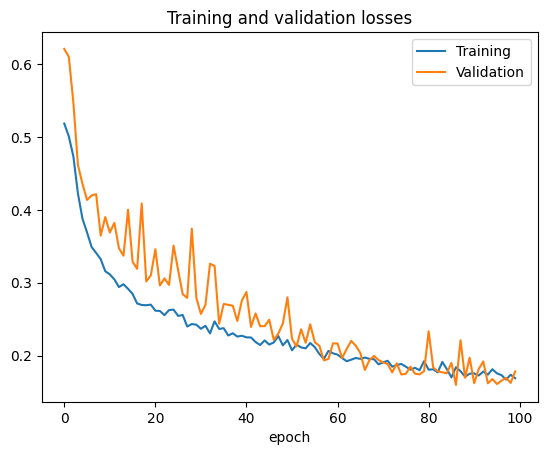

In [17]:
# PLOT GRAPH BETWEEN TRAINING AND VALIDATION LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title("Training and validation losses")
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

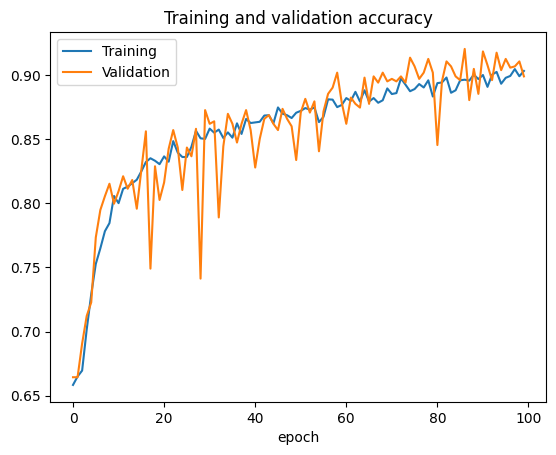

In [18]:
# PLOT GRAPH BETWEEN TRAINING AND VALIDATION LOSS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title("Training and validation accuracy")
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

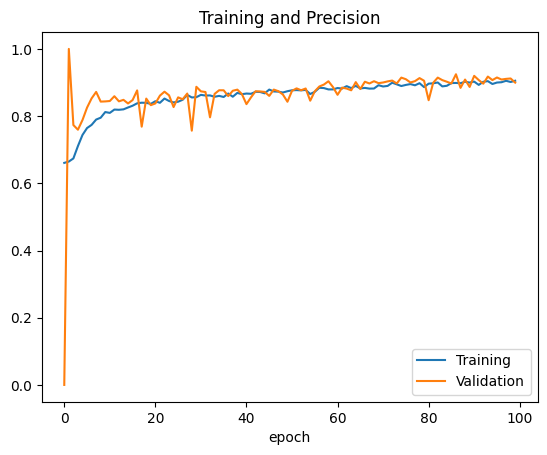

In [19]:
# PLOT GRAPH BETWEEN TRAINING AND VALIDATION LOSS
plt.plot(history.history['Precision'])
plt.plot(history.history['val_Precision'])
plt.legend(['Training', 'Validation'])
plt.title("Training and Precision")
plt.xlabel('epoch')

In [21]:
# Get test accuracy, loss, and other metrics
results = model.evaluate(test_generator)
print("Test Set Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - Precision: 0.9247 - Recall: 0.9202 - accuracy: 0.9212 - f1_score: 0.9224 - loss: 0.1325
Test Set Results:
loss: 0.13786916434764862
compile_metrics: 0.9192546606063843


In [22]:
from keras.preprocessing import image

In [55]:
# Set the image path
img_path = 'Image_Path'  # Replace with your specific image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(64, 64))  # Resize image to model input size
img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 150, 150, 3)

# Make prediction
prediction = model.predict(img_array)
predicted_class = (prediction[0][0])  # Threshold to classify



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


In [56]:
print(predicted_class)

0.016229058


In [52]:
# Set the image path
img_path = 'Image_Path'  # Replace with your specific image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(64, 64))  # Resize image to model input size
img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 150, 150, 3)

# Make prediction
prediction = model.predict(img_array)
predicted_class = (prediction[0][0])  # Threshold to classify



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [53]:
print(predicted_class)

1.2797327e-06


In [57]:
# Output the result
if predicted_class > 0.01611:
    print(f"The report from {img_path} is COVID-19 Positive")
else:
    print(f"The report from {img_path} is COVID-19 Negative")

The report from Dataset/Data/test/COVID19/COVID19(462).jpg is COVID-19 Positive
